In [70]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import re
import string
import seaborn as sns
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from itertools import chain
from nltk.corpus import stopwords
from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold
import random
from sklearn.metrics import roc_auc_score
from numpy import count_nonzero

pd.options.display.max_rows=1000
pd.options.display.max_colwidth = 300

# Read Data

In [3]:
files = sorted(filter(lambda x: x.endswith('.txt'), os.listdir('./labeled_articles')))

files_1 = list(filter(lambda x: x[-5] == '1', files))
files_2 = list(filter(lambda x: x[-5] == '2', files))
files_3 = list(filter(lambda x: x[-5] == '3', files))

In [4]:
def get_files_num_df(files_num):
    """this function reads all files annotated by #num person: 
    returns dataframe with domain, section, text and label"""
    annotate_num = files_num[0][-5]
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    dfs = []
    for file in files_num:
        with open('./labeled_articles/' + file, 'r') as f:
            domain = file.split('_')[0]
            section_name = None
            for line in f:
                if line.startswith('###'):
                    section_name = line.replace('#', '').strip()
                else:
                    label, *text = line.replace('--', ' ').split()
                    text = ' '.join(text)
                    dfs.append(pd.DataFrame({'text': [text], 
                                  'section': [section_name],
                                  'domain': [domain],
                                  'label_{}'.format(annotate_num): [label]
                                 }))

    df_num = pd.concat(dfs, axis=0).reset_index(drop=True)
    return df_num

In [5]:
df_1 = get_files_num_df(files_1)
df_2 = get_files_num_df(files_2)
df_3 = get_files_num_df(files_3)

In [6]:
print('df_1.shape is ', df_1.shape)
print('df_2.shape is ', df_2.shape)
print('df_3.shape is ', df_3.shape)

df_1.shape is  (1039, 4)
df_2.shape is  (1039, 4)
df_3.shape is  (1039, 4)


In [7]:
res = pd.concat([df_1, df_2[['label_2']], df_3[['label_3']]], axis=1)

In [8]:
res.shape

(1039, 6)

In [9]:
res.head(2)

,domain,label_1,section,text,label_2,label_3
0,arxiv,MISC,abstract,The Minimum Description Length principle for online sequence estimation/prediction in a proper learning setup is studied,MISC,OWNX
1,arxiv,MISC,abstract,"If the underlying model class is discrete, then the total expected square loss is a particularly interesting performance measure: (a) this quantity is finitely bounded, implying convergence with probability one, and (b) it additionally specifies the convergence speed",MISC,MISC


# True Label Establish

The true label is the label assigned by at least two of the three annotators.

In case, there is no majority label, the label provided by annotator three (the "expert" annotator) is used.  

In [10]:
res.loc[:, 'label'] = res['label_3']

mask_1_eq_2 = res['label_1'] == res['label_2']
mask_1_eq_3 = res['label_1'] == res['label_3']
mask_3_eq_2 = res['label_3'] == res['label_2']

res.loc[mask_1_eq_2, 'label'] = res.loc[mask_1_eq_2, 'label_1']
res.loc[mask_1_eq_3, 'label'] = res.loc[mask_1_eq_3, 'label_1']
res.loc[mask_3_eq_2, 'label'] = res.loc[mask_3_eq_2, 'label_3']

res.drop(['label_1', 'label_2', 'label_3'], axis=1, inplace=True)

# Base Features

 prepare text for tf-idf

In [13]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
res.loc[:, 'words'] = res['text'].apply(lambda x: word_tokenize(regex.sub('', x)))

In [14]:
with open('./word_lists/stopwords.txt', 'r') as f:
    stopwords = f.read().strip().split('\n')

stopwords.extend(['t', 's', 'm', 're'])

In [15]:
def lower_stops_join(list_of_words, stopwords):
    wrds = list(filter(lambda x: x not in stopwords, list_of_words))
    wrds = ' '.join(wrds).lower()
    return wrds

In [16]:
res['for_tfidf'] = res['words'].apply(lambda x: lower_stops_join(x, stopwords))

In [17]:
# position in section
res.loc[:, 'is_first_sent'] = ((res['section'] == 'abstract').astype(int).diff() != 0)
res.loc[:, 'is_last_sent'] = (res['is_first_sent'][::-1].astype(int).diff()[::-1].fillna(-1) == -1)

In [18]:
# base word count features
res.loc[:, 'word_cnt'] = res['for_tfidf'].apply(lambda x: len(x.split()))

res.loc[:, 'w_len_max'] = res['for_tfidf'].apply(lambda x: max(list(map(len, x.split()))))
res.loc[:, 'w_len_min'] = res['for_tfidf'].apply(lambda x: min(list(map(len, x.split()))))
res.loc[:, 'w_len_np.mean'] = res['for_tfidf'].apply(lambda x: np.mean(list(map(len, x.split()))))
res.loc[:, 'w_len_np.median'] = res['for_tfidf'].apply(lambda x: np.median(list(map(len, x.split()))))

res.loc[:, 'CITATION'] = res['for_tfidf'].apply(lambda x: 'citation' in x)
res.loc[:, 'NUMBER'] = res['for_tfidf'].apply(lambda x: 'number' in x)
res.loc[:, 'SYMBOL'] = res['for_tfidf'].apply(lambda x: 'symbol' in x)

In [38]:
# transforming binary and one hot features
bin_cols = ['CITATION', 'NUMBER', 'SYMBOL', 'is_first_sent', 'is_last_sent']
for col in bin_cols:
    res.loc[:, col] = res[col].astype(int)

le_domain = LabelEncoder()
le_section = LabelEncoder()

le_domain.fit(res['domain'])
le_section.fit(res['section'])

res['domain_encoded'] = le_domain.transform(res['domain'])
res['section_encoded'] = le_section.transform(res['section'])

ohe_domain = OneHotEncoder()
ohe_section = OneHotEncoder()
ohe_domain.fit(res['domain_encoded'].values.reshape(-1,1))
ohe_section.fit(res['section_encoded'].values.reshape(-1,1))

dfOneHot_domain = pd.DataFrame(
    ohe_domain.transform(res['domain_encoded'].values.reshape(-1,1)).toarray(),
    columns = ['domain_{}'.format(name) for name in le_domain.classes_]
)
res = pd.concat([res, dfOneHot_domain], axis=1)

dfOneHot_pos = pd.DataFrame(
    ohe_section.transform(res['section_encoded'].values.reshape(-1,1)).toarray(),
    columns = ['section_{}'.format(name) for name in le_section.classes_]
)
res = pd.concat([res, dfOneHot_pos], axis=1)

In [39]:
res.head(1)

,domain,section,text,label,words,for_tfidf,is_first_sent,is_last_sent,word_cnt,w_len_max,...,CITATION,NUMBER,SYMBOL,domain_encoded,section_encoded,domain_arxiv,domain_jdm,domain_plos,section_abstract,section_introduction
0,arxiv,abstract,The Minimum Description Length principle for online sequence estimation/prediction in a proper learning setup is studied,MISC,"[The, Minimum, Description, Length, principle, for, online, sequence, estimationprediction, in, a, proper, learning, setup, is, studied]",the minimum description length principle online sequence estimationprediction proper learning setup studied,1,0,12,20,...,0,0,0,0,0,1.0,0.0,0.0,1.0,0.0


# Some Analytics

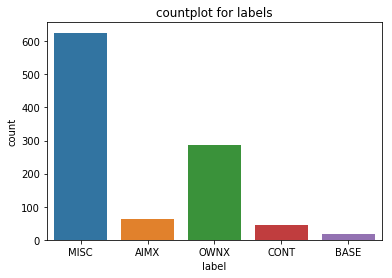

In [32]:
plt.title('countplot for labels')
sns.countplot(res['label'])
plt.show()

/Users/ann/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


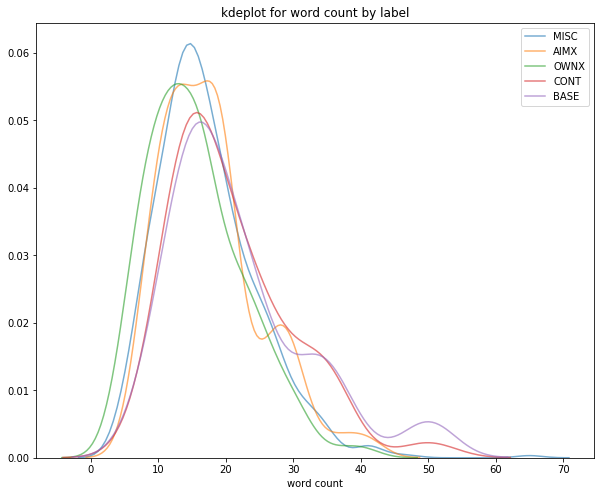

In [33]:
plt.figure(figsize=(10,8))
plt.xlabel('word count')
plt.title('kdeplot for word count by label')
for label in res['label'].unique():
    sns.kdeplot(res.loc[res['label'] == label, 'word_cnt'], label=label, alpha=0.6)
plt.legend()
plt.show();

In [42]:
# popular words by label
for label in res['label'].unique():
    all_words = list(chain(*res[res['label'] == label]['for_tfidf'].apply(lambda x: x.split())))
    all_words = list(filter(lambda x: x not in stopwords, all_words))
    all_words = list(map(lambda x: x.lower(), all_words))
    cntr = Counter(all_words)
    print(label)
    print(cntr.most_common(7), '\n')

MISC
[('citation', 391), ('this', 69), ('more', 58), ('been', 57), ('not', 57), ('model', 51), ('symbol', 47)] 

AIMX
[('we', 36), ('this', 31), ('paper', 22), ('study', 14), ('model', 13), ('new', 9), ('how', 8)] 

OWNX
[('we', 126), ('this', 41), ('our', 40), ('number', 37), ('section', 29), ('model', 23), ('citation', 23)] 

CONT
[('citation', 28), ('not', 13), ('this', 11), ('ion', 10), ('however', 9), ('use', 9), ('been', 9)] 

BASE
[('citation', 19), ('our', 7), ('this', 6), ('we', 6), ('face', 5), ('model', 5), ('were', 4)] 



/Users/ann/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


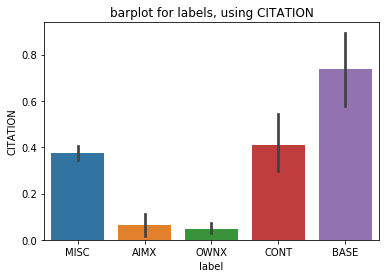

In [34]:
plt.title('barplot for labels, using CITATION')
sns.barplot(
    x='label',
    y='CITATION',
    data=res,
    estimator=np.mean,
    ci=90
)
plt.show()

/Users/ann/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


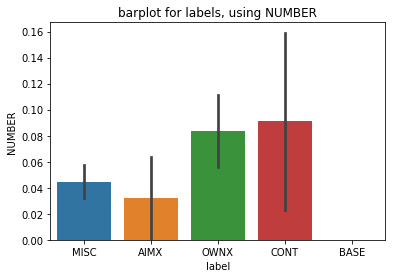

In [35]:
plt.title('barplot for labels, using NUMBER')
sns.barplot(
    x='label',
    y='NUMBER',
    data=res,
    estimator=np.mean,
    ci=90
)
plt.show()

/Users/ann/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


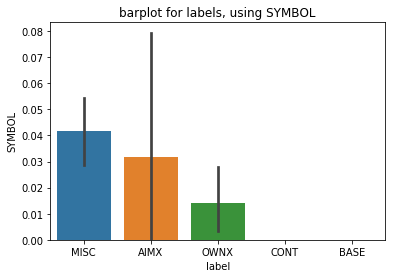

In [36]:
plt.title('barplot for labels, using SYMBOL')
sns.barplot(
    x='label',
    y='SYMBOL',
    data=res,
    estimator=np.mean,
    ci=90
)
plt.show()

# Getting Target

In [43]:
le_label = LabelEncoder()
le_label.fit(res['label'])

res.loc[:, 'label_encoded'] = le_label.transform(res['label'])

ohe_label = OneHotEncoder()
ohe_label.fit(res['label_encoded'].values.reshape(-1,1))

y_label = pd.DataFrame(
    ohe_label.transform(res['label_encoded'].values.reshape(-1,1)).toarray(),
    columns = ['label_{}'.format(name) for name in le_label.classes_]
)

In [44]:
y_label.head(3)

,label_AIMX,label_BASE,label_CONT,label_MISC,label_OWNX
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0


# Train Test Split

In [46]:
# base features
data_cols = ['word_cnt', 'w_len_max',
       'w_len_min', 'w_len_np.mean', 'w_len_np.median', 'CITATION', 'NUMBER',
       'SYMBOL', 'domain_arxiv', 'domain_jdm', 'domain_plos', 'section_abstract',
       'section_introduction', 'is_first_sent', 'is_last_sent']

# TEST data is used only to evaluate final model
# TRAIN data is to split in 5-fold-CV
TRAIN, TEST, y_label_train, y_label_test = train_test_split(
                                                            res, 
                                                            y_label, 
                                                            test_size=0.15, 
                                                            random_state=3, 
                                                            stratify=res['label_encoded']
                                                        )

TRAIN.reset_index(inplace=True, drop=True)
TEST.reset_index(inplace=True, drop=True)
y_label_train.reset_index(inplace=True, drop=True)
y_label_test.reset_index(inplace=True, drop=True)

# CV
skf = StratifiedKFold(n_splits=5, random_state=43)
cv_split = list(skf.split(TRAIN[data_cols], TRAIN['label_encoded']))

In [245]:
print('TRAIN.shape =', TRAIN.shape)
print('TEST.shape  =', TEST.shape)

TRAIN.shape = (883, 24)
TEST.shape  = (156, 24)


## Unbalansed Classes

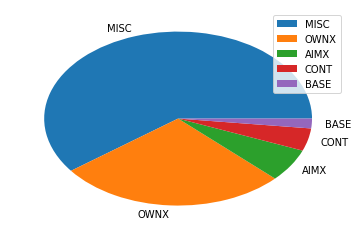

In [47]:
plt.pie(TRAIN['label'].value_counts().values, labels=TRAIN['label'].value_counts().index)
plt.legend()
plt.show()

Augmentation used:

*  None

*  oversampling ( repeat examples of small classes BASE CONT AIMX until their size's equal to OWNX's )

*  random_deletion ( label remains, recommended parameters are used from "EDA: Easy Data Augmentation ..." by Jason Wei, Kai Zou ) 

# Main functions:

### for plot & score

In [49]:
def compute_roc_auc(y_true, y_prob, class_names):
    """ this function computes roc_auc """
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, name in enumerate(class_names):
        fpr[name], tpr[name], _ = roc_curve(y_true.values[:, i], y_prob[:, i])
        roc_auc[name] = auc(fpr[name], tpr[name])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.values.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[name] for name in class_names]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for name in class_names:
        mean_tpr += interp(all_fpr, fpr[name], tpr[name])

    # Finally average it and compute AUC
    mean_tpr /= len(class_names)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return roc_auc

def show_roc_plot(y_true, y_prob, n_classes = 5):
    """ this function shows a plot for multiclass roc_auc """
    # Compute ROC curve and ROC area for each class
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true.values[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.values.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(12,10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'gray'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='{0} (area = {1:0.2f})'
                 ''.format(y_true.columns[i].split('_')[1], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### for model

In [78]:
class FullFarsch():
    """Class based on Train data for fitting all models (tf-idf, augmentation, xgboost) on Train
        and predicting on everything.
    """
    def __init__(self, X_train, y_train, xgb_kwargs, 
                 random_deletion_kwargs=dict(n=4, alpha=0.1),
                 tfidf_kwargs=dict(stop_words=None, max_features=100)):
        self.X_train = X_train
        self.y_train = y_train
        self.xgb_kwargs = xgb_kwargs
        self.random_deletion_kwargs = random_deletion_kwargs
        self.tfidf_kwargs = tfidf_kwargs
        
    def fit_tfidf(self, stop_words=None, max_features=100):
        
        tfidf = TfidfVectorizer(max_features=max_features, stop_words=stop_words)
        tfidf.fit(self.X_train['for_tfidf'].values)
        
        self.tfidf_model = tfidf
        
        tfidf_feats = self.tfidf_model.transform(self.X_train['for_tfidf'].values).todense()
        sparsity = 1.0 - count_nonzero(tfidf_feats) / tfidf_feats.size
        # print('tfidf features sparsity =', sparsity)
        
        self.X_train.drop(['for_tfidf'], axis=1, inplace=True)
        
        tfidf_feats_df = pd.DataFrame(tfidf_feats, columns=['tf_idf_{}'.format(i) for i in range(max_features)])
        
        self.X_train = pd.concat([self.X_train.reset_index(drop=True), 
                                  tfidf_feats_df.reset_index(drop=True)], 
                                 axis=1)
        
    def oversampling(self):
        """adds rows to train_df - minority labels copies - until they have optimal size for train"""
        # print('X_train.shape before oversampling = ', self.X_train.shape)
        
        self.X_train.loc[:, 'lab'] = self.y_train
        
        # label 4 has an optimal size for training 
        n_ownx = self.X_train[self.X_train['lab'] == 4].shape[0]
        # minority labels are 0, 1, 2
        add_rows = []
        for label in [0, 1, 2]:
            n_rep = n_ownx // self.X_train[self.X_train['lab'] == label].shape[0]
            for _, row in self.X_train[self.X_train['lab'] == label].iterrows():
                add_rows.extend([row] * n_rep)
                
        oversam = list(map(lambda x: x.to_frame().transpose(), add_rows))
        oversam_df = pd.concat(oversam, axis=0).reset_index(drop=True)
        cols = self.X_train.columns
        X_new = pd.concat([self.X_train[cols], oversam_df[cols]],axis=0).reset_index(drop=True)
        self.y_train = X_new['lab'].astype(int)
        self.X_train = X_new.drop(['lab'], axis=1)
        
        # print('X_train.shape after oversampling = ', self.X_train.shape)
        
    def random_deletion(self, n=4, alpha=0.1):
        """makes n samples for each minority labels by deletion word with probability alpha"""
        
        # print('X_train.shape before random_deletion = ', self.X_train.shape)
        self.X_train.loc[:, 'lab'] = self.y_train
        
        def random_deletion(x, alpha=alpha):
            new_x = []
            for word in x.split():
                if random.random() > alpha:
                    new_x.append(word)
            return ' '.join(new_x)
        
        add_rows = []
        for label in [0, 1, 2]:
            for _, row in self.X_train[self.X_train['lab'] == label].iterrows():
                original_text = row['for_tfidf']
                for i in range(n):
                    temp_df = row.to_frame().transpose()
                    temp_df.loc[:, 'for_tfidf'] = random_deletion(original_text)
                    add_rows.append(temp_df)
        # restore_word_feats, because random deletion changed statistics          
        random_deletion_df = self.restore_word_feats(pd.concat(add_rows, axis=0).reset_index(drop=True))
        cols = self.X_train.columns
        X_new = pd.concat([self.X_train[cols], random_deletion_df[cols]],axis=0).reset_index(drop=True)
        self.y_train = X_new['lab'].astype(int)
        self.X_train = X_new.drop(['lab'], axis=1)
        # print('X_train.shape after random_deletion = ', self.X_train.shape)
        
    def restore_word_feats(self, df):
        """calculates word statistics"""
        df.loc[:, 'word_cnt'] = df['for_tfidf'].apply(lambda x: len(x.split()))

        df.loc[:, 'w_len_max'] = df['for_tfidf'].apply(lambda x: max(list(map(len, x.split()))))
        df.loc[:, 'w_len_min'] = df['for_tfidf'].apply(lambda x: min(list(map(len, x.split()))))
        df.loc[:, 'w_len_np.mean'] = df['for_tfidf'].apply(lambda x: np.mean(list(map(len, x.split()))))
        df.loc[:, 'w_len_np.median'] = df['for_tfidf'].apply(lambda x: np.median(list(map(len, x.split()))))

        df.loc[:, 'CITATION'] = df['for_tfidf'].apply(lambda x: 'citation' in x)
        df.loc[:, 'NUMBER'] = df['for_tfidf'].apply(lambda x: 'number' in x)
        df.loc[:, 'SYMBOL'] = df['for_tfidf'].apply(lambda x: 'symbol' in x)
        
        return df
        
    def fit_final_model(self, augmentation_mode=None):
        """final model pipeline with fitting all its components"""
        
        if augmentation_mode == 'oversampling':
            self.oversampling()
        elif augmentation_mode == 'random_deletion':
            self.random_deletion(**self.random_deletion_kwargs)
        
        # fit tfidf
        self.fit_tfidf(**self.tfidf_kwargs)
        
        # for fixing type-bug
        for col in self.X_train:
            self.X_train.loc[:, col] = self.X_train[col].astype(float)
        
        # fit model    
        self.model = xgb.sklearn.XGBClassifier(**self.xgb_kwargs)
        self.model.fit(self.X_train, self.y_train)
            
    def predict_with_final_model(self, X):
        """ prediction returns p_val(probabilities) and p_class(labels) """
        tfidf_feats = self.tfidf_model.transform(X['for_tfidf'].values).todense()
        X.drop(['for_tfidf'], axis=1, inplace=True)
        tfidf_feats_df = pd.DataFrame(tfidf_feats, 
                                      columns=['tf_idf_{}'.format(i) for i in range(tfidf_feats.shape[1])])
        
        X = pd.concat([X.reset_index(drop=True), tfidf_feats_df.reset_index(drop=True)], axis=1)
        for col in X:
            X.loc[:, col] = X[col].astype(float)
        
        p_val = self.model.predict_proba(X)
        p_class = self.model.predict(X)
        
        return p_val, p_class

### 1. XGBoost на базовых признаках

In [51]:
xgb_kwargs = dict(max_depth=2, eta=1, n_estimators=87, random_state=43, reg_alpha=0.001, reg_lambda=0.001)

In [52]:
xgb_scores = []

for cv_idx_tr, cv_idx_val in cv_split:
    X_train = TRAIN.loc[cv_idx_tr, data_cols]
    y_train = TRAIN.loc[cv_idx_tr, 'label_encoded']
    
    X_val = TRAIN.loc[cv_idx_val, data_cols]
    y_val = TRAIN.loc[cv_idx_val, 'label_encoded']
    
    model = xgb.sklearn.XGBClassifier(**xgb_kwargs)
    model.fit(X_train, y_train)
    
    class_mapping = le_label.classes_[model.classes_]
    p_val = model.predict_proba(X_val)
    
    roc_auc = compute_roc_auc(
        y_label_train.loc[cv_idx_val, list(map(lambda x: 'label_' + x, class_mapping))],
        p_val,
        class_names=class_mapping
    )
    xgb_scores.append(roc_auc)

xgb_scores = pd.DataFrame(xgb_scores)

In [53]:
xgb_scores

,AIMX,BASE,CONT,MISC,OWNX,macro,micro
0,0.784091,0.738571,0.616228,0.780504,0.814129,0.751665,0.901095
1,0.721829,0.672381,0.689706,0.763328,0.801139,0.734625,0.901236
2,0.748209,0.572254,0.664835,0.721765,0.767475,0.700068,0.894628
3,0.640771,0.878613,0.716822,0.806469,0.858910,0.784716,0.911980
4,0.530793,0.385965,0.662104,0.819298,0.874008,0.663705,0.904826


In [54]:
for col in xgb_scores.columns:
    print(f'{col} score:\t{xgb_scores[col].mean():.3f} (± {xgb_scores[col].std():.3f})')

AIMX score:	0.685 (± 0.101)
BASE score:	0.650 (± 0.185)
CONT score:	0.670 (± 0.037)
MISC score:	0.778 (± 0.038)
OWNX score:	0.823 (± 0.043)
macro score:	0.727 (± 0.047)
micro score:	0.903 (± 0.006)


### 2. выбор параметра max_features  для tf_idf

In [67]:
max_features_grid = list(range(100,800,50))

In [68]:
train_and_tfidf_cols = data_cols + ['for_tfidf']

In [ ]:
tfidf_scores_dict = {}

for max_feat in max_features_grid:
    tfidf_kwargs=dict(stop_words=None, max_features=max_feat)
    xgb_scores = []

    for cv_idx_tr, cv_idx_val in cv_split:
        X_train = TRAIN.loc[cv_idx_tr, train_and_tfidf_cols]
        y_train = TRAIN.loc[cv_idx_tr, 'label_encoded']

        X_val = TRAIN.loc[cv_idx_val, train_and_tfidf_cols]
        y_val = TRAIN.loc[cv_idx_val, 'label_encoded']

        full_model = FullFarsch(X_train, y_train, xgb_kwargs=xgb_kwargs, tfidf_kwargs=tfidf_kwargs)
        full_model.fit_final_model()

        p_val, p_class = full_model.predict_with_final_model(X_val)

        roc_auc = compute_roc_auc(
            y_label_train.loc[cv_idx_val, list(map(lambda x: 'label_' + x, class_mapping))],
            p_val,
            class_names=class_mapping
        )
        xgb_scores.append(roc_auc)
    
    xgb_scores = pd.DataFrame(xgb_scores)  
    
    print('\n')
    print('max_feat = ', max_feat)
    for col in xgb_scores.columns:
        print(f'{col} score:\t{xgb_scores[col].mean():.3f} (± {xgb_scores[col].std():.3f})')
    
    tfidf_scores_dict[max_feat] = xgb_scores
    print('\n')

    

In [ ]:
# принты tfidf_scores удалены для удобного чтения

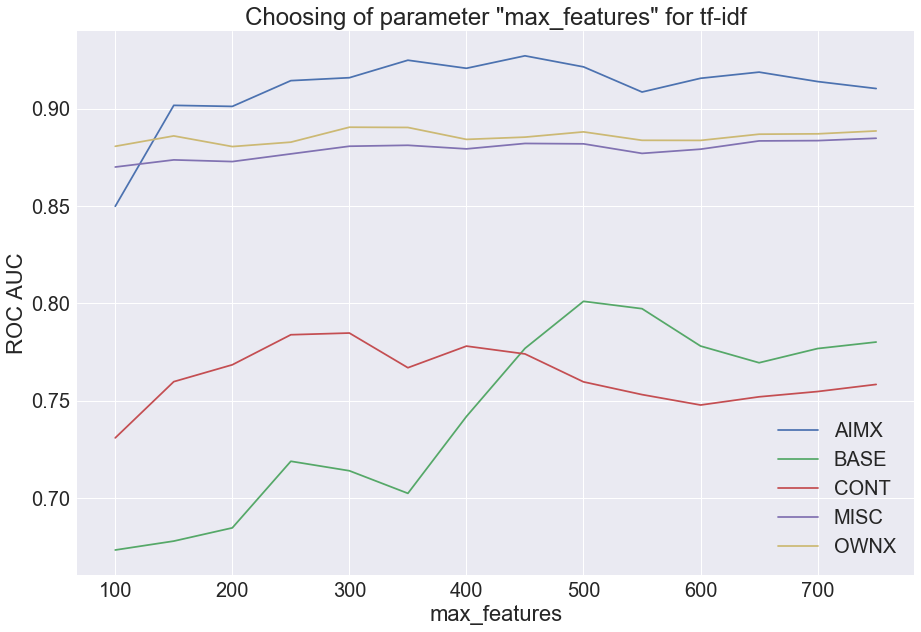

In [238]:
xs = sorted(tfidf_scores_dict.keys())

plt.figure(figsize=(15, 10))
plt.title('Choosing of parameter "max_features" for tf-idf')
for cls in class_mapping:
    ys = [tfidf_scores_dict[x][cls].mean() for x in xs]
    plt.plot(xs, ys, label=cls)
plt.xlabel('max_features')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

При значении параметра 500 достигается наилучший скор по классу BASE. 

Но, уже начиная с 200, все остальные классы выходят на плато.

## Сравнение аугментации на лучшем tf-idf

#### max_features = 500

In [80]:
%%time 
# best tf-idf
tfidf_kwargs=dict(stop_words=None, max_features=500)
aug_scores_dict = dict()

for aug, rd_kwargs in zip(
    [None, 'oversampling', 'random_deletion', 'random_deletion'], 
    [None, None, dict(alpha=0.1, n=4), dict(alpha=0.05, n=8)]
):
    
    xgb_scores = []

    for cv_idx_tr, cv_idx_val in cv_split:
        X_train = TRAIN.loc[cv_idx_tr, train_and_tfidf_cols]
        y_train = TRAIN.loc[cv_idx_tr, 'label_encoded']

        X_val = TRAIN.loc[cv_idx_val, train_and_tfidf_cols]
        y_val = TRAIN.loc[cv_idx_val, 'label_encoded']

        full_model = FullFarsch(X_train, y_train, 
                                xgb_kwargs=xgb_kwargs, tfidf_kwargs=tfidf_kwargs,
                                random_deletion_kwargs=rd_kwargs)
        full_model.fit_final_model(augmentation_mode=aug)

        p_val, p_class = full_model.predict_with_final_model(X_val)

        roc_auc = compute_roc_auc(
            y_label_train.loc[cv_idx_val, list(map(lambda x: 'label_' + x, class_mapping))],
            p_val,
            class_names=class_mapping
        )
        xgb_scores.append(roc_auc)

    xgb_scores = pd.DataFrame(xgb_scores)  

    print('\n')
    print('aug = ', aug)
    print('rd_kwargs ', rd_kwargs)
    for col in xgb_scores.columns:
        print(f'{col} score:\t{xgb_scores[col].mean():.3f} (± {xgb_scores[col].std():.3f})')
    params = 'aug_{}_rd_{}'.format(aug, rd_kwargs)
    aug_scores_dict[params] = xgb_scores
    print('\n')    



aug =  None
rd_kwargs  None
AIMX score:	0.922 (± 0.046)
BASE score:	0.801 (± 0.077)
CONT score:	0.760 (± 0.108)
MISC score:	0.882 (± 0.033)
OWNX score:	0.888 (± 0.027)
macro score:	0.854 (± 0.034)
micro score:	0.940 (± 0.010)




aug =  oversampling
rd_kwargs  None
AIMX score:	0.921 (± 0.062)
BASE score:	0.813 (± 0.171)
CONT score:	0.775 (± 0.083)
MISC score:	0.860 (± 0.021)
OWNX score:	0.850 (± 0.027)
macro score:	0.848 (± 0.047)
micro score:	0.926 (± 0.012)




aug =  random_deletion
rd_kwargs  {'alpha': 0.1, 'n': 4}
AIMX score:	0.916 (± 0.060)
BASE score:	0.796 (± 0.124)
CONT score:	0.725 (± 0.025)
MISC score:	0.869 (± 0.024)
OWNX score:	0.857 (± 0.042)
macro score:	0.835 (± 0.032)
micro score:	0.930 (± 0.013)




aug =  random_deletion
rd_kwargs  {'alpha': 0.05, 'n': 8}
AIMX score:	0.913 (± 0.058)
BASE score:	0.782 (± 0.161)
CONT score:	0.769 (± 0.061)
MISC score:	0.861 (± 0.025)
OWNX score:	0.843 (± 0.026)
macro score:	0.838 (± 0.037)
micro score:	0.915 (± 0.013)


CPU times: us

#### max_features = 200

In [81]:
%%time
# best tf-idf
tfidf_kwargs=dict(stop_words=None, max_features=200)
aug_scores_dict_200 = dict()

for aug, rd_kwargs in zip(
    [None, 'oversampling', 'random_deletion', 'random_deletion'], 
    [None, None, dict(alpha=0.1, n=4), dict(alpha=0.05, n=8)]
):
    
    xgb_scores = []

    for cv_idx_tr, cv_idx_val in cv_split:
        X_train = TRAIN.loc[cv_idx_tr, train_and_tfidf_cols]
        y_train = TRAIN.loc[cv_idx_tr, 'label_encoded']

        X_val = TRAIN.loc[cv_idx_val, train_and_tfidf_cols]
        y_val = TRAIN.loc[cv_idx_val, 'label_encoded']

        full_model = FullFarsch(X_train, y_train, 
                                xgb_kwargs=xgb_kwargs, tfidf_kwargs=tfidf_kwargs,
                                random_deletion_kwargs=rd_kwargs)
        full_model.fit_final_model(augmentation_mode=aug)

        p_val, p_class = full_model.predict_with_final_model(X_val)

        roc_auc = compute_roc_auc(
            y_label_train.loc[cv_idx_val, list(map(lambda x: 'label_' + x, class_mapping))],
            p_val,
            class_names=class_mapping
        )
        xgb_scores.append(roc_auc)

    xgb_scores = pd.DataFrame(xgb_scores)  

    print('\n')
    print('aug = ', aug)
    print('rd_kwargs ', rd_kwargs)
    for col in xgb_scores.columns:
        print(f'{col} score:\t{xgb_scores[col].mean():.3f} (± {xgb_scores[col].std():.3f})')
    params = 'aug_{}_rd_{}'.format(aug, rd_kwargs)
    aug_scores_dict_200[params] = xgb_scores
    print('\n')    



aug =  None
rd_kwargs  None
AIMX score:	0.901 (± 0.073)
BASE score:	0.685 (± 0.049)
CONT score:	0.768 (± 0.106)
MISC score:	0.873 (± 0.025)
OWNX score:	0.881 (± 0.027)
macro score:	0.826 (± 0.038)
micro score:	0.936 (± 0.013)




aug =  oversampling
rd_kwargs  None
AIMX score:	0.920 (± 0.064)
BASE score:	0.785 (± 0.171)
CONT score:	0.796 (± 0.088)
MISC score:	0.858 (± 0.020)
OWNX score:	0.853 (± 0.041)
macro score:	0.846 (± 0.039)
micro score:	0.926 (± 0.016)




aug =  random_deletion
rd_kwargs  {'alpha': 0.1, 'n': 4}
AIMX score:	0.908 (± 0.076)
BASE score:	0.768 (± 0.142)
CONT score:	0.774 (± 0.049)
MISC score:	0.866 (± 0.030)
OWNX score:	0.868 (± 0.037)
macro score:	0.841 (± 0.044)
micro score:	0.931 (± 0.015)




aug =  random_deletion
rd_kwargs  {'alpha': 0.05, 'n': 8}
AIMX score:	0.911 (± 0.071)
BASE score:	0.758 (± 0.122)
CONT score:	0.778 (± 0.067)
MISC score:	0.850 (± 0.019)
OWNX score:	0.849 (± 0.040)
macro score:	0.834 (± 0.031)
micro score:	0.914 (± 0.015)


CPU times: us

### На 500 фичах tf-idf 
 аугментация ухудшает результаты среднего roc_auc (macro score)

* aug =  None
* rd_kwargs  None
* AIMX score:	**0.922 (± 0.046)**
* BASE score:	**0.801 (± 0.077)**
* CONT score:	**0.760 (± 0.108)**
* MISC score:	**0.882 (± 0.033)**
* OWNX score:	**0.888 (± 0.027)**
* macro score:	**0.854 (± 0.034)**
* micro score:	**0.940 (± 0.010)**

###  Но на 200 фичах
метрики очень близки к 500 (за счет oversamplingа) + считается быстрее в 2 раза

* aug =  oversampling
* rd_kwargs  None
* AIMX score:	**0.920 (± 0.064)**
* BASE score:	**0.785 (± 0.171)**
* CONT score:	**0.796 (± 0.088)**
* MISC score:	**0.858 (± 0.020)**
* OWNX score:	**0.853 (± 0.041)**
* macro score:	**0.846 (± 0.039)**
* micro score:	**0.926 (± 0.016)**

### поэтому выбраны  200 фичей tf-idf и oversampling

# XGB Tuning

В качестве модели выбран XGBoost на деревьях, так как он быстрый и мощный, не требует предобработки данных. 

In [84]:
def train_model(xgb_kwargs):
    # best tf-idf
    tfidf_kwargs=dict(stop_words=None, max_features=200)
    augmentation_mode = 'oversampling'
    xgb_scores = []

    for cv_idx_tr, cv_idx_val in cv_split:
        X_train = TRAIN.loc[cv_idx_tr, train_and_tfidf_cols]
        y_train = TRAIN.loc[cv_idx_tr, 'label_encoded']

        X_val = TRAIN.loc[cv_idx_val, train_and_tfidf_cols]
        y_val = TRAIN.loc[cv_idx_val, 'label_encoded']

        full_model = FullFarsch(X_train, y_train, 
                                xgb_kwargs=xgb_kwargs, tfidf_kwargs=tfidf_kwargs)
        full_model.fit_final_model(augmentation_mode=augmentation_mode)

        p_val, p_class = full_model.predict_with_final_model(X_val)

        roc_auc = compute_roc_auc(
            y_label_train.loc[cv_idx_val, list(map(lambda x: 'label_' + x, class_mapping))],
            p_val,
            class_names=class_mapping
        )
        xgb_scores.append(roc_auc)

    xgb_scores = pd.DataFrame(xgb_scores)
    
    return xgb_scores

In [99]:
parameters_grid = {
    'learning_rate': [0.03, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 1.0],
    'random_state': [43]
}

parameters_list = list(ParameterGrid(parameters_grid))

gridsearch_df = []

for parameters_kwargs in parameters_list:
    print('Checking {}'.format(parameters_kwargs))
    scores = train_model(parameters_kwargs)
    mean_scores = {col: scores[col].mean() for col in scores.columns}
    gridsearch_df.append({'parameters': parameters_kwargs, **mean_scores})
    print('Done, macro score: {:.3f}'.format(mean_scores['macro']))
    
gridsearch_df = pd.DataFrame(gridsearch_df)

Checking {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'random_state': 43}
Done, macro score: 0.837
Checking {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'random_state': 43}
Done, macro score: 0.837
Checking {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'random_state': 43}
Done, macro score: 0.831
Checking {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 43}
Done, macro score: 0.846
Checking {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 43}
Done, macro score: 0.847
Checking {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 43}
Done, macro score: 0.860
Checking {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 3, 'random_state': 43}
Done, macro score: 0.852
Checking {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 43}
Done, macro score: 0.856
Checking {'colsample_bytree': 0.7, 'learning_rate': 0

 максимизируем средний скор по всем классам, а так же скор по самым сложным классам (представленным в наименьших размерах)

In [100]:
gridsearch_df.sort_values(['macro', 'BASE', 'CONT'], ascending=[False] * 3)

,AIMX,BASE,CONT,MISC,OWNX,macro,micro,parameters
5,0.915736,0.815661,0.782700,0.880583,0.881995,0.859884,0.942687,"{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 43}"
8,0.908007,0.820882,0.779226,0.883694,0.876275,0.858740,0.942702,"{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 7, 'random_state': 43}"
17,0.908608,0.846431,0.755617,0.874513,0.872996,0.856557,0.939778,"{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'random_state': 43}"
7,0.912506,0.818427,0.769517,0.877507,0.873954,0.855646,0.941524,"{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 43}"
16,0.916409,0.810813,0.769939,0.879493,0.874576,0.855250,0.941198,"{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 43}"
6,0.908342,0.803924,0.779270,0.873309,0.871404,0.852250,0.938664,"{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 3, 'random_state': 43}"
14,0.889963,0.825058,0.752999,0.871729,0.873909,0.848015,0.936662,"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 43}"
4,0.906037,0.798075,0.750563,0.877978,0.880379,0.847349,0.939257,"{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 43}"
13,0.902429,0.812297,0.745727,0.874853,0.875235,0.847161,0.936326,"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 43}"
12,0.913765,0.797625,0.757183,0.869562,0.863140,0.846313,0.931149,"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 43}"


выбрана первая строка с параметрами: 

`{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 43}`

# Results

### TEST data

In [101]:
tfidf_kwargs=dict(stop_words=None, max_features=200)
augmentation_mode = 'oversampling'
xgb_kwargs = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 43}

In [102]:
fin_model = FullFarsch(TRAIN.loc[:, train_and_tfidf_cols], TRAIN['label_encoded'], 
                       xgb_kwargs=xgb_kwargs, tfidf_kwargs=tfidf_kwargs)
fin_model.fit_final_model(augmentation_mode=augmentation_mode)

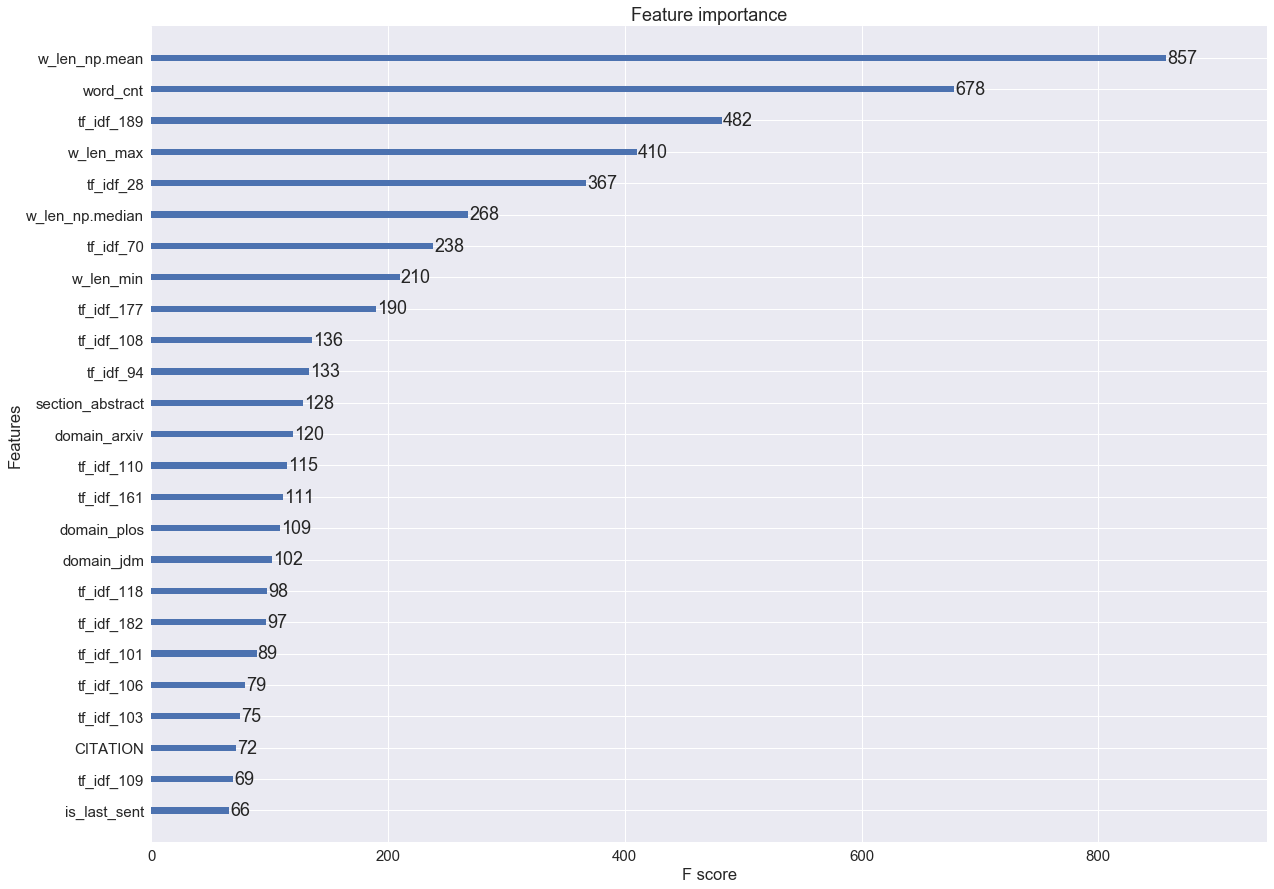

In [104]:
sns.set(font_scale=1.5) 
plt.figure(figsize=(20, 15))
plot_importance(fin_model.model, ax=plt.gca(), max_num_features=25)
plt.show();

In [105]:
p_val, p_class = fin_model.predict_with_final_model(TEST.loc[:, train_and_tfidf_cols])

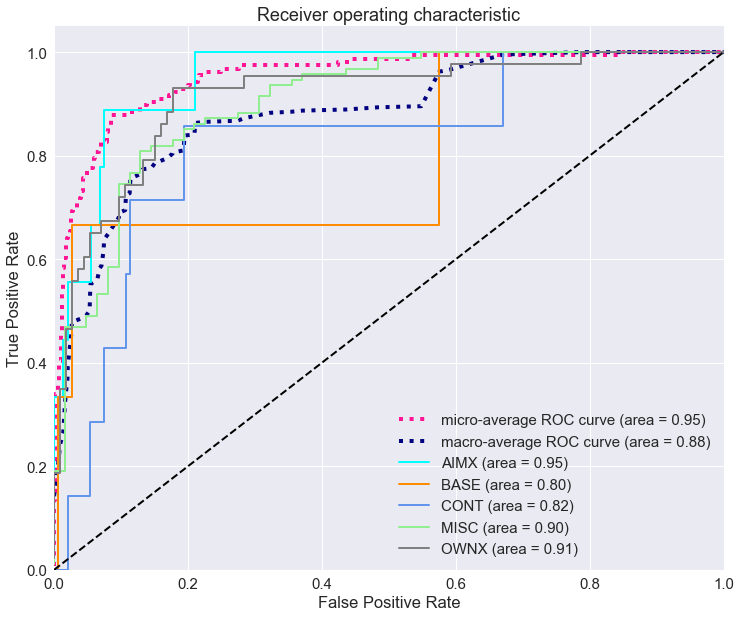

In [106]:
show_roc_plot(
    y_label_test[list(map(lambda x: 'label_' + x, class_mapping))],
    p_val
)

In [107]:
m = confusion_matrix(p_class, TEST.loc[:, 'label_encoded'])
m1 = m / m.sum(axis=0)

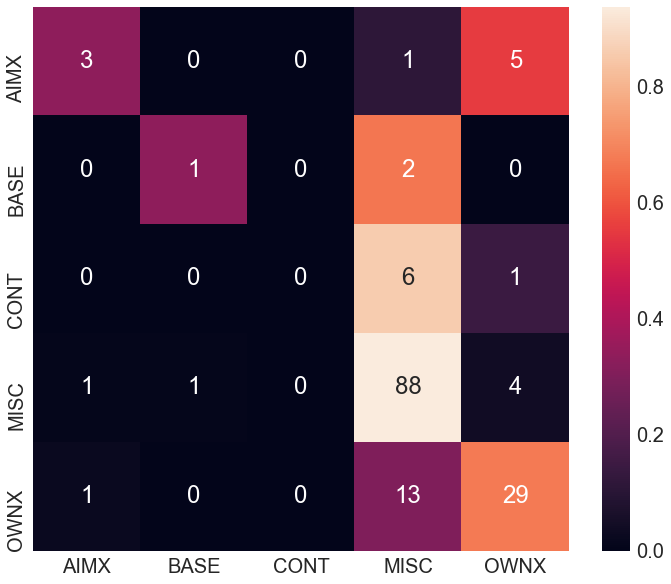

In [108]:
sns.set(font_scale=2) 
plt.figure(figsize=(12,10))
sns.heatmap(m1.T, annot=m.T, xticklabels=class_mapping, yticklabels=class_mapping,fmt='g')
plt.show()

# Noise Data (10 %)

In [199]:
def some_screw(x):
    x = list(x)
    letter_cnt = random.randint(1, 3)
    if len(x) < letter_cnt:
        letter_cnt = len(x)
        
    def delete(x, letter_cnt):
        for i in range(letter_cnt):
            del x[random.randint(0, len(x) - 1)]
        return x
    
    def insert(x, letter_cnt):
        for i in range(letter_cnt):
            random_letter = string.ascii_lowercase[random.randint(0, 26 - 1)]
            x.insert(random.randint(0, len(x) - 1), random_letter)
        return x
            
    def swap(x, letter_cnt):
        for i in range(letter_cnt):
            first = random.randint(0, len(x) - 1)
            second = random.randint(0, len(x) - 1)
            x[first], x[second] = x[second], x[first]  
        return x
    
    screw_way = random.randint(1, 3) 
    
    if screw_way == 1:
        return ''.join(delete(x, letter_cnt))
    elif screw_way == 2:
        return ''.join(insert(x, letter_cnt))
    else:
        return ''.join(swap(x, letter_cnt))
                
def screw_smth(x):
    # 10% words of each sentence
    n = np.floor(0.1 * len(x))
    for i in range(int(n)):
        idx = random.randint(0, len(x) - 1)
        x[idx] = some_screw(x[idx])
    return x

In [205]:
noisy_data = res.copy(deep=True)

In [206]:
noisy_data.loc[:, 'words'] = noisy_data['words'].apply(screw_smth)

In [208]:
# other featunoisy_data remain the same
noisy_data['for_tfidf'] = noisy_data['words'].apply(lambda x: lower_stops_join(x, stopwords))
noisy_data.loc[:, 'word_cnt'] = noisy_data['for_tfidf'].apply(lambda x: len(x.split()))

noisy_data.loc[:, 'w_len_max'] = noisy_data['for_tfidf'].apply(lambda x: max(list(map(len, x.split()))))
noisy_data.loc[:, 'w_len_min'] = noisy_data['for_tfidf'].apply(lambda x: min(list(map(len, x.split()))))
noisy_data.loc[:, 'w_len_np.mean'] = noisy_data['for_tfidf'].apply(lambda x: np.mean(list(map(len, x.split()))))
noisy_data.loc[:, 'w_len_np.median'] = noisy_data['for_tfidf'].apply(lambda x: np.median(list(map(len, x.split()))))

In [209]:
# train_test_split
TRAIN_n, TEST_n, y_label_train_n, y_label_test_n = train_test_split(
                                                            noisy_data, 
                                                            y_label, 
                                                            test_size=0.15, 
                                                            random_state=3, 
                                                            stratify=noisy_data['label_encoded']
                                                        )

TRAIN_n.reset_index(inplace=True, drop=True)
TEST_n.reset_index(inplace=True, drop=True)
y_label_train_n.reset_index(inplace=True, drop=True)
y_label_test_n.reset_index(inplace=True, drop=True)

# Results NOISY

In [210]:
tfidf_kwargs=dict(stop_words=None, max_features=200)
augmentation_mode = 'oversampling'
xgb_kwargs = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 43}

In [211]:
fin_model = FullFarsch(TRAIN_n.loc[:, train_and_tfidf_cols], TRAIN_n['label_encoded'], 
                       xgb_kwargs=xgb_kwargs, tfidf_kwargs=tfidf_kwargs)
fin_model.fit_final_model(augmentation_mode=augmentation_mode)

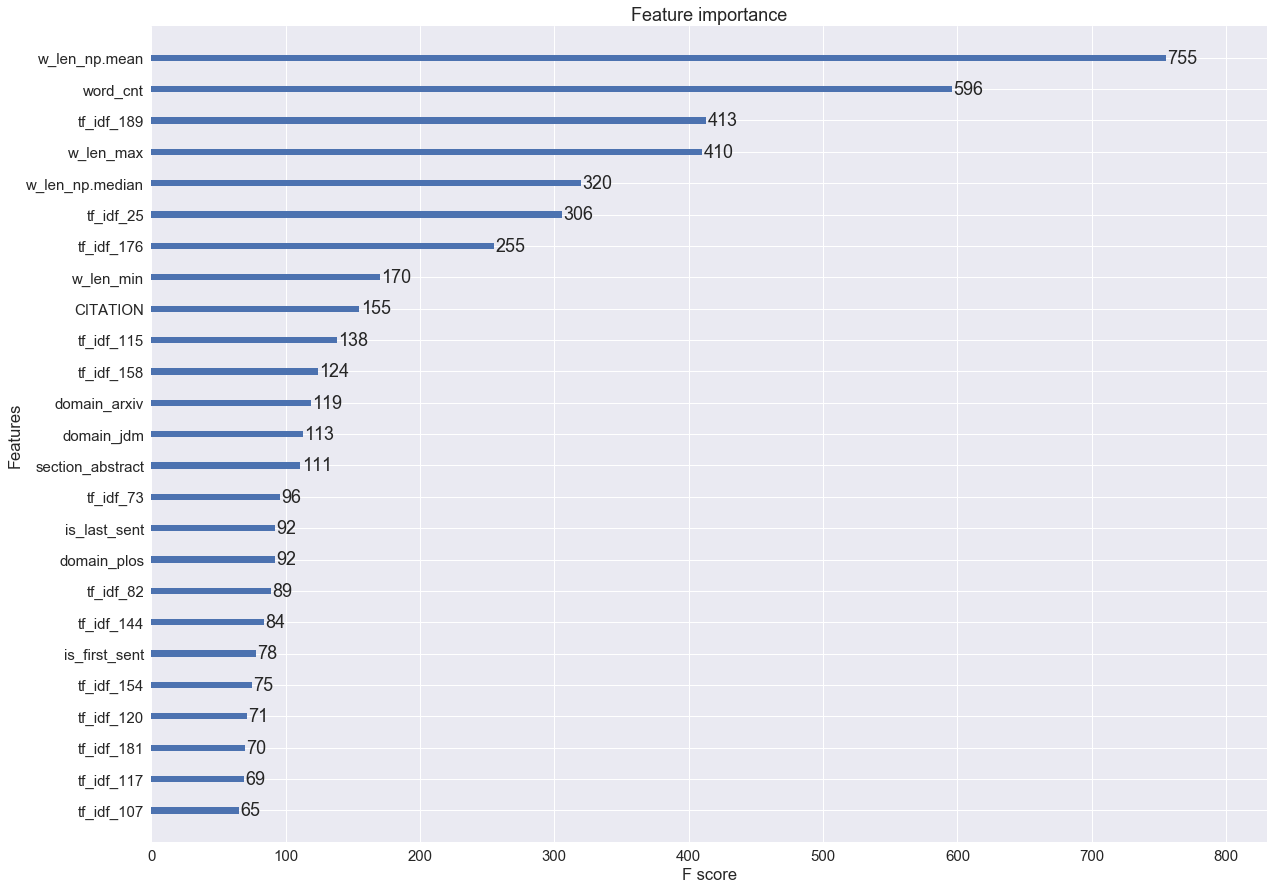

In [212]:
sns.set(font_scale=1.5) 
plt.figure(figsize=(20, 15))
plot_importance(fin_model.model, ax=plt.gca(), max_num_features=25)
plt.show();

Изменилась важность фичей: для зашумленных данных в топах стало больше количественных статистик, и они поднялись выше по значимости.

In [213]:
p_val, p_class = fin_model.predict_with_final_model(TEST_n.loc[:, train_and_tfidf_cols])

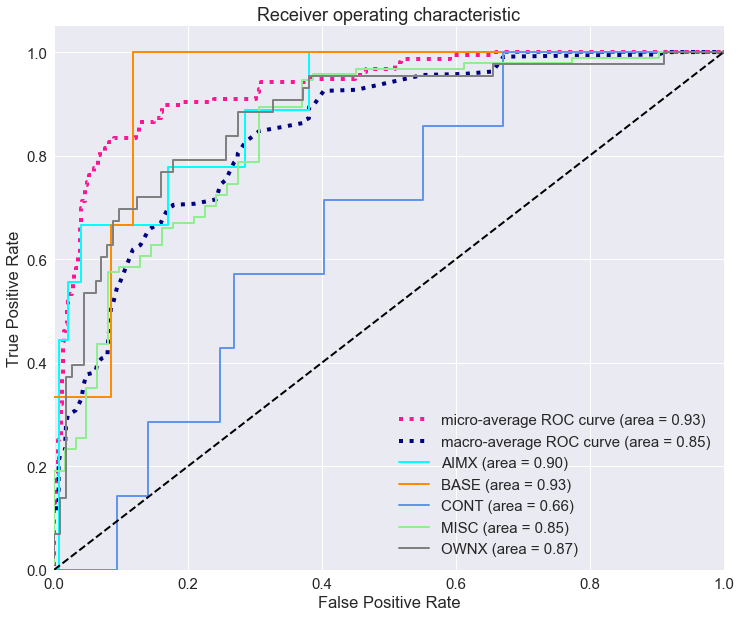

In [214]:
show_roc_plot(
    y_label_test_n[list(map(lambda x: 'label_' + x, class_mapping))],
    p_val
)

In [215]:
m = confusion_matrix(p_class, TEST_n.loc[:, 'label_encoded'])
m1 = m / m.sum(axis=0)

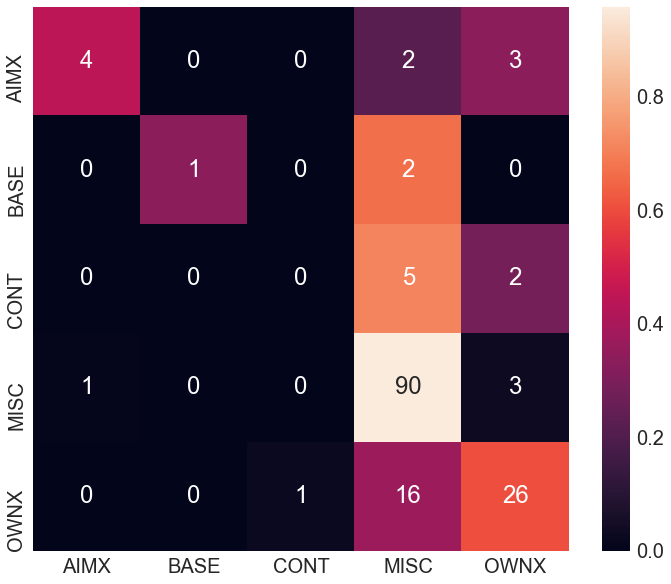

In [216]:
sns.set(font_scale=2) 
plt.figure(figsize=(12,10))
sns.heatmap(m1.T, annot=m.T, xticklabels=class_mapping, yticklabels=class_mapping,fmt='g')
plt.show()

C шумом результаты остались практически такими же:
* Во-первых, зашумление было несильное - порядка 10% слов;
* Во-вторых, кроме tf-idf, важными признаками являются статистики на количестве слов и букв, которые не так сильно поддаются зашумлению;
* В-третьих, мощная модель наилучшим образом выделила важные признаки. 

In [267]:
print('roc_auc       original \t noisy ') 
print('-------------------------------')
print('Средний         ', 0.88, '\t', 0.85)
print('AIMX           ', 0.95 ,'\t',  0.9)
print('BASE           ', 0.8 ,'\t',  0.93) 
print('CONT           ', 0.82 ,'\t',  0.66)
print('MISC           ', 0.9 ,'\t',  0.85)
print('OWNX           ', 0.91 ,'\t',  0.87)


roc_auc       original 	 noisy 
-------------------------------
Средний          0.88 	 0.85
AIMX            0.95 	 0.9
BASE            0.8 	 0.93
CONT            0.82 	 0.66
MISC            0.9 	 0.85
OWNX            0.91 	 0.87
